In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Retrieve and Inspect Dataset

In [274]:
data = "inclusive_features_usage.xlsx"
df = pd.read_excel(data)

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 10000 non-null  object 
 1   feature_used            10000 non-null  object 
 2   session_duration        10000 non-null  float64
 3   engagement_score        10000 non-null  int64  
 4   accessibility_settings  10000 non-null  int64  
 5   age_group               10000 non-null  object 
 6   gender                  6003 non-null   object 
 7   additional_attributes   3997 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 625.1+ KB


## Data Cleaning & Preparation

In [276]:
df.isnull().sum()

user_id                      0
feature_used                 0
session_duration             0
engagement_score             0
accessibility_settings       0
age_group                    0
gender                    3997
additional_attributes     6003
dtype: int64

In [277]:
df['session_duration'] = df['session_duration'].fillna(df['session_duration'].mean())
df['engagement_score'] = df['engagement_score'].fillna(df['engagement_score'].mean())

In [278]:
df['gender'] = df['gender'].fillna('Prefer not to say')
df['gender'].value_counts()

gender
Prefer not to say    3997
Male                 2029
Female               1990
Non-Binary           1984
Name: count, dtype: int64

In [279]:
df['additional_attributes'] = df['additional_attributes'].fillna('No additional attributes')
df['additional_attributes'].value_counts()

additional_attributes
No additional attributes    6003
Person of Color             2018
LGBTQ+                      1979
Name: count, dtype: int64

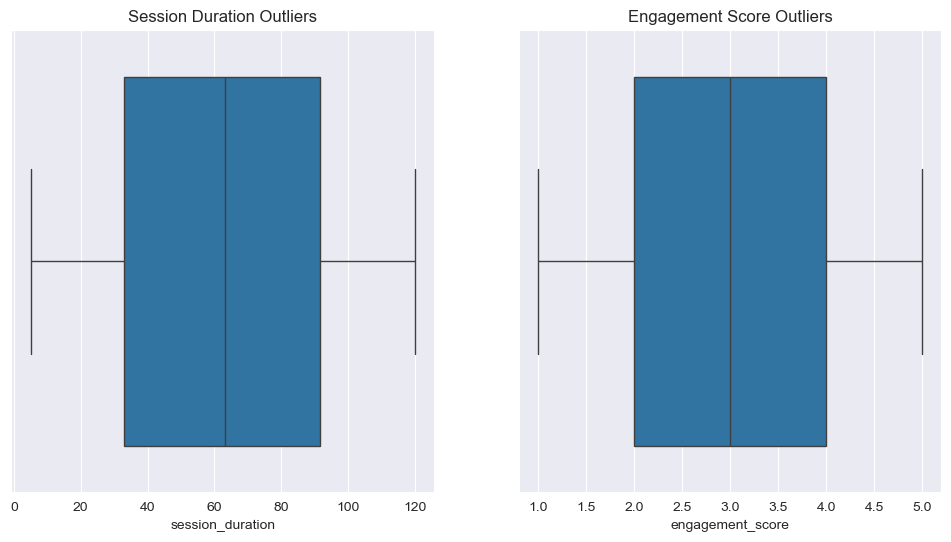

In [280]:
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1) 
sns.boxplot(x=df['session_duration']) 
plt.title('Session Duration Outliers') 
plt.subplot(1, 2, 2) 
sns.boxplot(x=df['engagement_score']) 
plt.title('Engagement Score Outliers') 
plt.show()

In [281]:
q_low = df['session_duration'].quantile(0.01) 
q_high = df['session_duration'].quantile(0.99) 
df['session_duration'] = df['session_duration'].clip(lower=q_low, upper=q_high) 
q_low = df['engagement_score'].quantile(0.01) 
q_high = df['engagement_score'].quantile(0.99) 
df['engagement_score'] = df['engagement_score'].clip(lower=q_low, upper=q_high)

In [282]:
# explanation: 
df['high_accessibility_user'] = [1 if x >= 3 else 0 for x in df['accessibility_settings']]

In [283]:
df['demographics'] = df['age_group'] + ' - ' + df['gender'] + ' - ' + df['additional_attributes']

In [284]:
df = df.drop('user_id', axis=1)

In [285]:
df.head()

,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user,demographics
0,Multilingual,60.77,4,4,Teenager,Prefer not to say,LGBTQ+,1,Teenager - Prefer not to say - LGBTQ+
1,Text-to-Speech,20.20,5,4,Professional,Non-Binary,No additional attributes,1,Professional - Non-Binary - No additional attr...
2,Colorblind Mode,93.78,2,2,Adult,Female,No additional attributes,0,Adult - Female - No additional attributes
3,Colorblind Mode,26.36,3,1,Adult,Prefer not to say,LGBTQ+,0,Adult - Prefer not to say - LGBTQ+
4,High Contrast Mode,91.67,5,1,Young Adult,Male,No additional attributes,0,Young Adult - Male - No additional attributes


## EDA

### Engagement Score Analysis

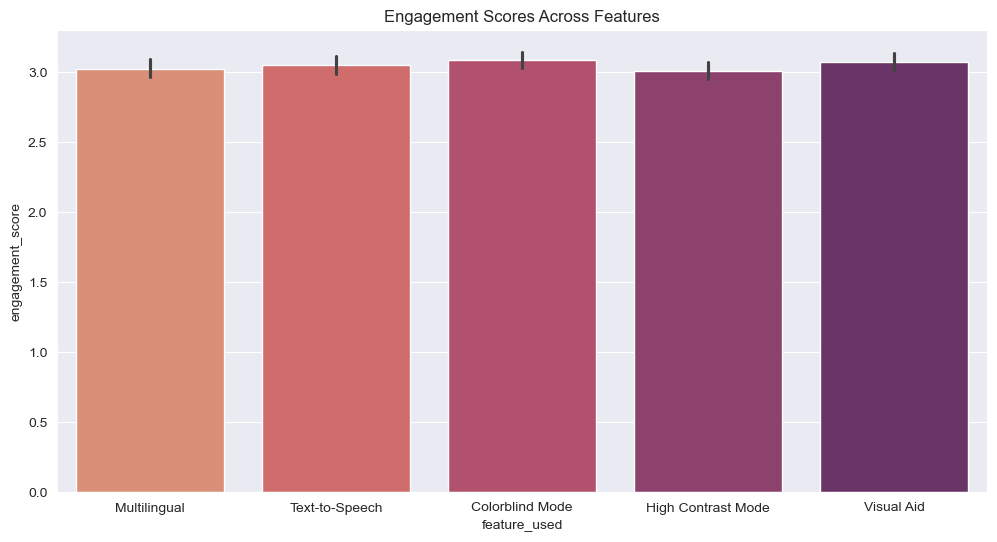

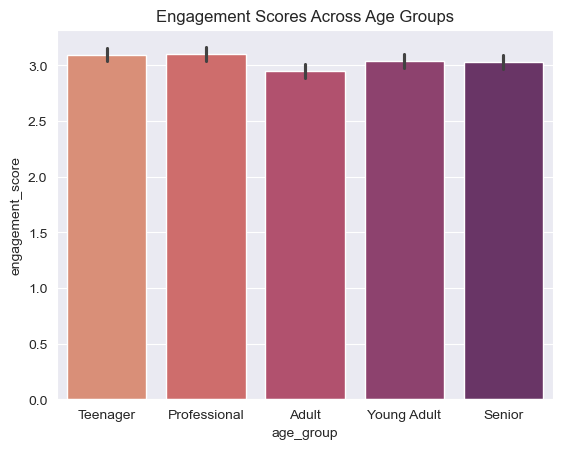

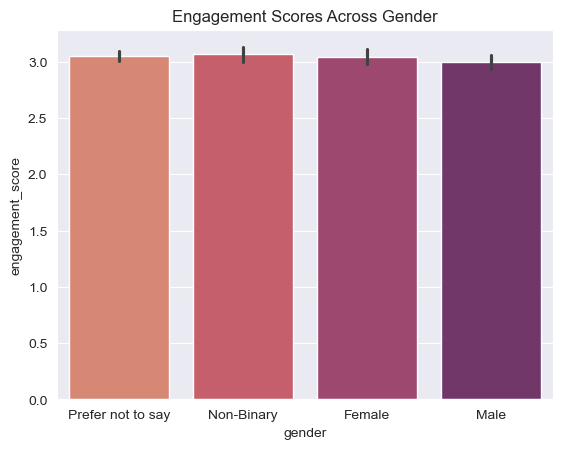

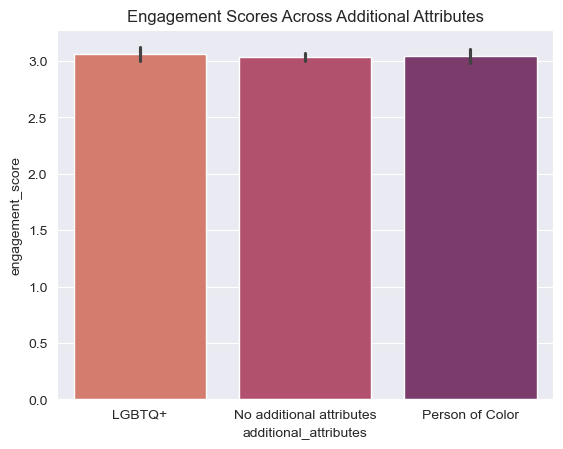

In [286]:
plt.figure(figsize=(12, 6))
# Engagement scores across different features
sns.barplot(x='feature_used', y='engagement_score', hue='feature_used', palette='flare', data=df) 
plt.title('Engagement Scores Across Features') 
plt.show()

# Engagement scores across age 
sns.barplot(x='age_group', y='engagement_score', hue='age_group', palette='flare', data=df)
plt.title('Engagement Scores Across Age Groups')
plt.show()

# Engagement scores across gender 
sns.barplot(x='gender', y='engagement_score', hue='gender', palette='flare', data=df)
plt.title('Engagement Scores Across Gender')
plt.show()

# Engagement scores across additional attributes
sns.barplot(x='additional_attributes', y='engagement_score', palette='flare', hue='additional_attributes', data=df)
plt.title('Engagement Scores Across Additional Attributes')
plt.show()

### Feature Usage by Demographic

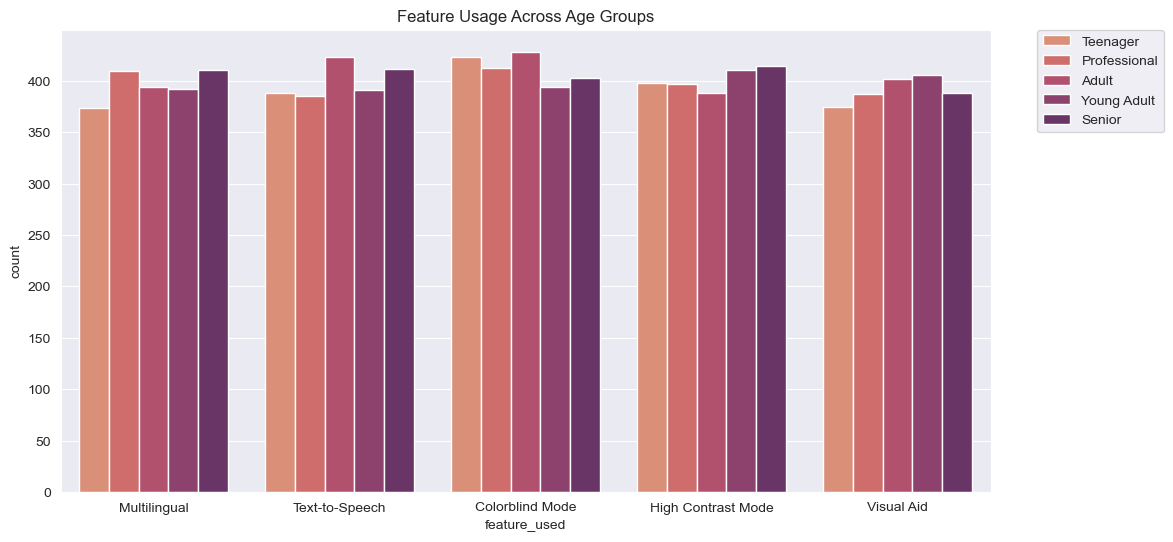

In [287]:
# feature usage across age groups
plt.figure(figsize=(12, 6)) 
sns.countplot(x='feature_used', hue='age_group', data=df, palette='flare') 
plt.title('Feature Usage Across Age Groups') 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

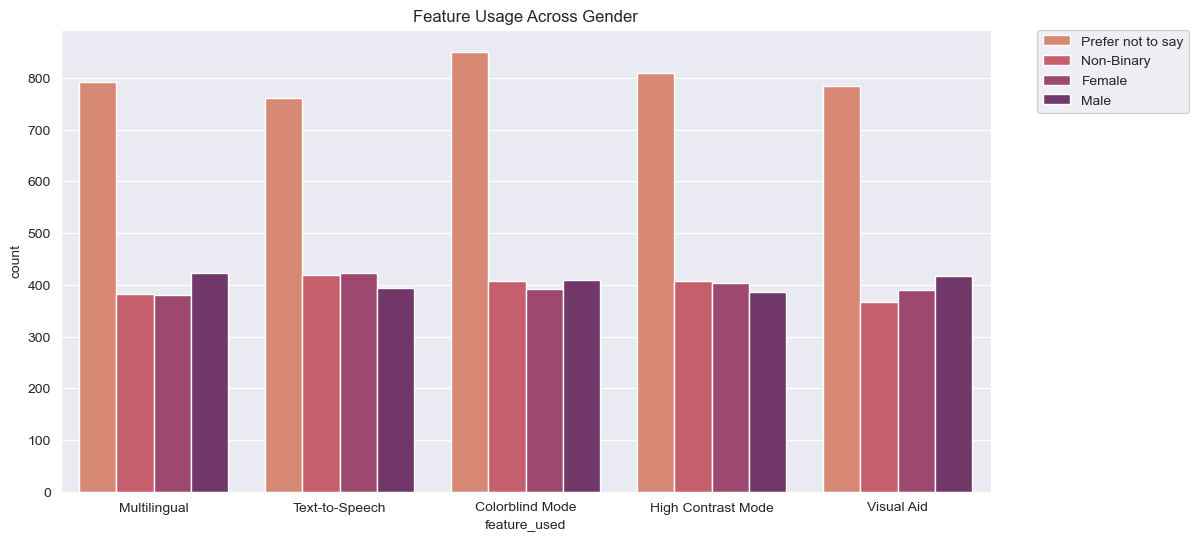

In [288]:
# feature usage across gender
plt.figure(figsize=(12, 6))
sns.countplot(x='feature_used', hue='gender', data=df, palette='flare')
plt.title('Feature Usage Across Gender')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

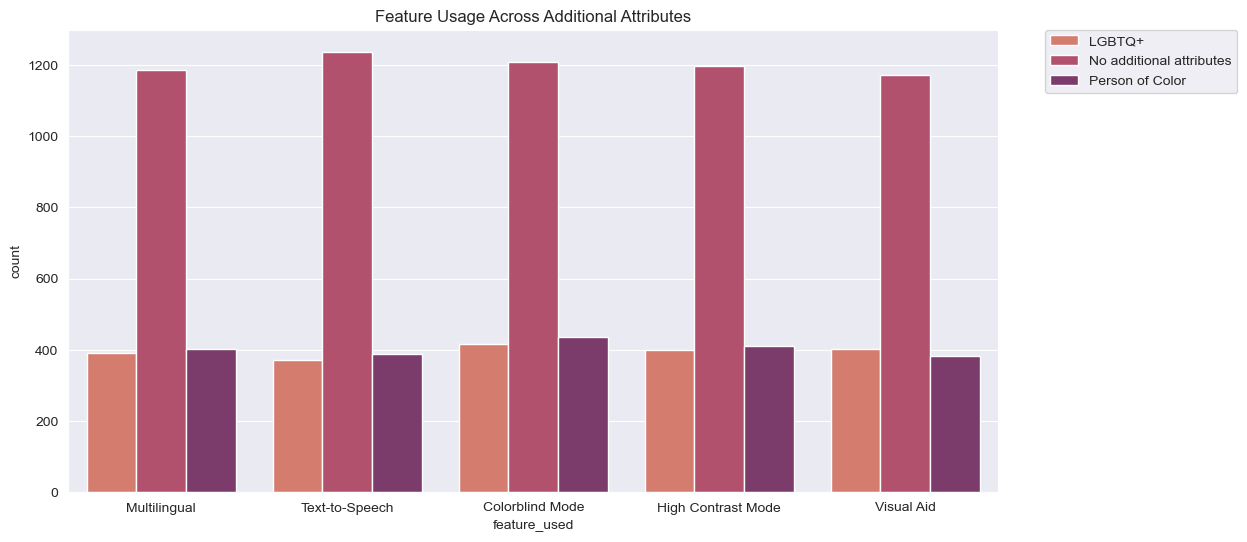

In [289]:
# feature usage across additional attributes
plt.figure(figsize=(12, 6))
sns.countplot(x='feature_used', hue='additional_attributes', data=df, palette='flare')
plt.title('Feature Usage Across Additional Attributes')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

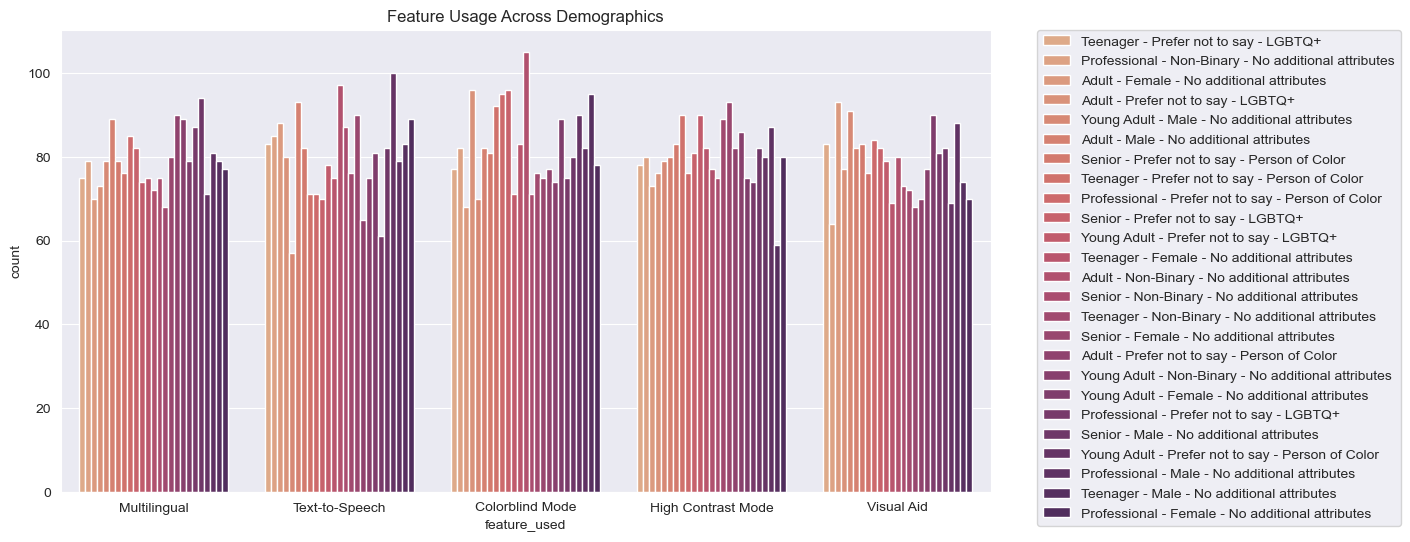

In [290]:
# feature usage across intersectionality (demographics)
plt.figure(figsize=(12, 6))
sns.countplot(x='feature_used', hue='demographics', data=df, palette='flare')
plt.title('Feature Usage Across Demographics')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Feature Engineering & Predictive Modeling

### New Features

In [291]:
# Average session_duration per feature_used
avg_session_duration = df.groupby('feature_used')['session_duration'].mean().reset_index()
avg_session_duration.columns = ['feature_used', 'avg_session_duration'] 
df = (df.merge(avg_session_duration, on='feature_used', how='left'))

In [292]:
df[['session_duration', 'avg_session_duration']]

,session_duration,avg_session_duration
0,60.77,62.901047
1,20.20,62.381241
2,93.78,62.818796
3,26.36,62.818796
4,91.67,62.150185
...,...,...
9995,110.11,61.954394
9996,22.44,61.954394
9997,12.91,62.901047
9998,19.23,62.901047


In [293]:
# Average engagement_score by accessibility_setting and demographics
avg_engagement_score = df.groupby(['accessibility_settings', 'age_group', 'gender'])['engagement_score'].mean().reset_index() 
avg_engagement_score.columns = ['accessibility_settings', 'age_group', 'gender', 'avg_engagement_score'] 
df = df.merge(avg_engagement_score, on=['accessibility_settings', 'age_group', 'gender'], how='left')

In [294]:
df[['engagement_score', 'avg_engagement_score']]

,engagement_score,avg_engagement_score
0,4,3.015038
1,5,3.133333
2,2,3.134328
3,3,3.045455
4,5,3.129630
...,...,...
9995,1,2.985507
9996,3,3.416667
9997,4,3.015625
9998,3,3.119403


### Predictive Model

#### Logical Regression

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [296]:
df.head()

,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user,demographics,avg_session_duration,avg_engagement_score
0,Multilingual,60.77,4,4,Teenager,Prefer not to say,LGBTQ+,1,Teenager - Prefer not to say - LGBTQ+,62.901047,3.015038
1,Text-to-Speech,20.20,5,4,Professional,Non-Binary,No additional attributes,1,Professional - Non-Binary - No additional attr...,62.381241,3.133333
2,Colorblind Mode,93.78,2,2,Adult,Female,No additional attributes,0,Adult - Female - No additional attributes,62.818796,3.134328
3,Colorblind Mode,26.36,3,1,Adult,Prefer not to say,LGBTQ+,0,Adult - Prefer not to say - LGBTQ+,62.818796,3.045455
4,High Contrast Mode,91.67,5,1,Young Adult,Male,No additional attributes,0,Young Adult - Male - No additional attributes,62.150185,3.129630


In [297]:
categorical_columns = ['feature_used', 'age_group', 'gender', 'additional_attributes','demographics']

label_encoder = LabelEncoder()
df['feature_used'] = label_encoder.fit_transform(df['feature_used'])
df['age_group'] = label_encoder.fit_transform(df['age_group'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['additional_attributes'] = label_encoder.fit_transform(df['additional_attributes'])

In [298]:
# features and target variable
features = ['feature_used', 'age_group', 'gender', 'additional_attributes']
X = df[features]
y = df['high_accessibility_user']

In [299]:
# split train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [300]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [301]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred) : 2.2%}')
print(f'Classification report: {classification_report(y_test, y_pred)}')

Accuracy score:  48.45%
Classification report:               precision    recall  f1-score   support

           0       0.49      0.50      0.49      1012
           1       0.48      0.47      0.48       988

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



An accuracy score of 48.45% indicates that the model correctly predicts slightly less than half of the users. This performance is close to random guessing, suggesting that the model may not be effectively learning from the input features.

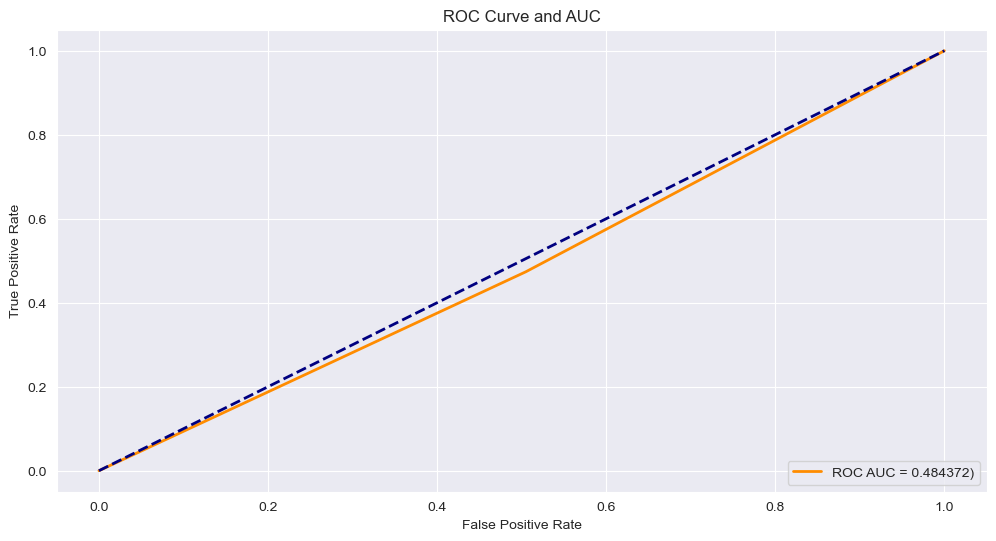

In [309]:
# Double-checking with ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve and AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

The ROC curve visualization reveals that the logistic regression model has an AUC score of 0.484. This score indicates that the model is performing slightly worse than random guessing, which would produce an AUC of 0.50 or 50%. This suggests that the model is not effectively learning from the input features when distinguishing between high-accessibility users and other users in the dataset. This correlates with the Accuracy score.

## Insight & Recommendations

### Key Findings Summary: 
For cleaning the Data and preparing it, I identified and handled missing values in the dataframe, particularly in the session_duration and engagement_score columns. Additionally, I replaced NaN values in the gender and additional_attributes columns with placeholders such as 'prefer not to say' or 'no additional attributes', inorder to avoid dropping rows. I also dropped the user_id column to ensure it did not interfere with the regression analysis. Users with three or more accessibility settings were classified as high usability users and categorized as 0s and 1s. This binary classification simplified the regression process, as it eliminated the need to convert categorical data into qualitative data. I then tested the high_accessibility_user variable against other features in the dataframe. Furthermore, I created a demographics column to facilitate intersectional analysis, allowing me to examine the influence of different demographic combinations on user behavior.

During the Exploratory Data Analysis, I found that the engagement score analysis did not produce highly interpretable results. However, the feature analysis against demographics revealed some interesting patterns. For instance, there is a high usage of Text-to-Speech and Color Blind Mode among adults, particularly when accessibility settings are enabled. Additionally, men are more likely to use Visual Aids and Color Blind Mode compared to other genders.

For predictive modeling, the logistic regression model performed poorly with an ROC AUC score of 0.484, indicating it was barely better than random guessing. This suggests that either the features provided are not strong predictors of high-accessibility users or that the logistic regression model may not be complex enough to capture the patterns. Future test would suggest using different models for better accuracy.

### Actionable Recommendations
A recommendation would be to actively promote the availability of accessibility settings to users, particularly seniors, who may be unaware of these options. By raising awareness of these features, we can increase engagement and ensure that more users benefit from the enhanced accessibility options available.